<b>Note:</b> I had made this type of analysis with a different notebook at first, but I couldn't find the notebook anymore, so this is recreating what I had done in the other notebook previously.
    
I might have used another seed in the other notebook, so the datapoints may not be 100% the same. However, the conclusions should still remain the same.

# 1. Imports

In [1]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
from matplotlib import pyplot as plt

# 2. Loading in the data

Please keep in mind that the points 2.1 and 2.2 are direct copies from cells in the w2v_similarities.ipynb file in the same directory.

## 2.1 The Postings datasets

cp. "Loading the dataset" in w2v_similarities.ipynb

In [2]:
#open csv's and join into one variable p
p1 = pd.read_csv("../input/Postings_01052019_15052019.csv", delimiter=";")
p2 = pd.read_csv("../input/Postings_16052019_31052019.csv", delimiter=";")
p = pd.concat([p1, p2])
p = p.reset_index()
p = p.drop(["index"], axis=1)

p will be split up in 30 bins in the end. It's important to sort the dataset by PostingCreatedAt in order to see a proper development over time in the final plots

In [3]:
p = p.sort_values(by="PostingCreatedAt")

## 2.2 The preprocessed vectors.pkl file

cp. "Opening the preprocessed vectors.pkl file" in w2v_similarities.ipynb

In [4]:
#open w2v embeddings pickles
w2vs = []
for i in range(9): #amount of vector_*.pkl files is hardcoded here!
    w2vs.append(pd.read_pickle(r'w2v/vectors_'+str(i)+'.pkl'))
w2v = pd.concat(w2vs)

## 2.3 uu_tuples

In the root directory of this repository you will find a directory named "uu_tuples/". It contains users that had their first point of contact. This data is separated in two files: "uu_first_contact_tuples_replies.csv" containing a first reply on the 15th day in the dataset, and "uu_first_contact_tuples_votes.csv" containing a first vote (upvote/downvote) captured between a user pair.

The question regarding word similarity is related to the first replies rather than the first votes. I had initially tried to compare the w2v similarities between the users in the first votes csv file and the overwhelming majority of them turned out to throw an exception because it turns out most users who leave votes don't leave (m)any comments.

Thus we're restricting ourselves to analyzing user pairs found in "uu_first_contact_tuples_replies.csv". Opening the file in the following code chunk.

In [5]:
uu = pd.read_csv("../uu_tuples/uu_first_contact_tuples_replies.csv")

In the following we can see the format of the file. 

In [6]:
uu.head(3)

,UserCommunityName_x,UserCommunityName_y
0,##V+##,Hašek
1,##V+##,Rotfunk
2,##V+##,dadadum


The dataset contains username pairs. The functions calculating w2v user pairs, to be found in section 3, require pairs of user IDs. For that reason, we're translating usernames to user IDs in the following.

This information gets extracted from the Postings CSV information that is saved in the variable in this notebook.

In [7]:
u_name_id = p[["UserCommunityName", "ID_CommunityIdentity"]]
u_name_id.head(3)

,UserCommunityName,ID_CommunityIdentity
91471,"lch fordere Sie auf, abzutreten.",640076
149878,The Gödelnumber of the Beast,137950
86,Meiner Ansicht nach,636346


The final uname_to_id dictionary translates usernames to IDs.

In [8]:
u_names = u_name_id["UserCommunityName"].tolist()
u_ids = u_name_id["ID_CommunityIdentity"].tolist()

uname_to_id = {u_names[i]: u_ids[i] for i in range(len(u_names))}

#Demonstration
print(uname_to_id["Hpolditsch"])
print(uname_to_id["##V+##"])
print(uname_to_id["dadadum"])

669286
10741
276321


### Translating the user-user pairs

They're stored in the variable named uu

In [9]:
# Creating new uu2 DataFrame
uu2 = pd.DataFrame()

uu2["ID_x"] = uu["UserCommunityName_x"].apply(lambda x: uname_to_id[x])
uu2["ID_y"] = uu["UserCommunityName_y"].apply(lambda x: uname_to_id[x])

uu2.head(3)

,ID_x,ID_y
0,10741,666563
1,10741,549757
2,10741,276321


# 3. Preparing the functions

## 3.1 Preparing functions to use for user similarity comparison

Direct copy from the "Preparing functions to use for user similarity comparison" section in the w2v_similarities.ipynb file.

In [10]:
#given a sentenct/paragraph/collection of words it returns the mean of the w2v weights
#these words need to be normalized which text_to_vector() does before calling this function
def get_w2v_averages(words):
    return w2v[w2v[0].isin(words)].iloc[:,1:].mean()

In [11]:
#splits up the dataset in df equal groups and creates a new column (named 0) assigning distinct numbers to each of the groups so it's possible to perform group operations afterwards
def equal_groups(df, chunks):
    amount_rows = df.shape[0]
    chunks = pd.Series(range(amount_rows)).apply(lambda x: int(x/(amount_rows/chunks)))
    chunks.index = df.index
    return pd.concat([chunks,df],axis=1)

In [12]:
#return averaged w2v from given sentence
def text_to_vector(text):
    text = text.lower() #lowercase words, all words in w2v dictionary are lowercase
    tokens = RegexpTokenizer(r'\w+').tokenize(text)
    tokens = [t for t in tokens if not t in stopwords.words('german')]
    return get_w2v_averages(tokens)

In [13]:
#given the dataset two users, and a chunk size, returns similarities
def w2v_similarities(user1, user2, chunks=1, df=p):
    df = equal_groups(p, chunks)
    vecs1 = get_user_vectors(df, user1)
    vecs2 = get_user_vectors(df, user2)
    return (np.dot(vecs1,vecs2.transpose())/(np.linalg.norm(vecs1, axis=1)*np.linalg.norm(vecs2, axis=1))).diagonal() #cosine similarity

In [14]:
#returns all vectors from the users. equal_groups(df, chunks) is expected as input for "df" here.
def get_user_vectors(df, userid):
    chunksize = df.tail(1)[0].iloc[0] + 1
    filtered = df[df["ID_CommunityIdentity"] == userid].fillna("")
    vectors = (filtered["PostingHeadline"] + " " + filtered["PostingComment"]).apply(lambda x: text_to_vector(x))
    grouped_vectors = equal_groups(vectors, chunksize).groupby([0]).mean()
    return grouped_vectors.reindex(index = np.arange(0,chunksize), method="ffill")

In [15]:
def plot_user_similarities(user1, user2, chunksize, df=p):
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,df.shape[0], chunksize), w2v_similarities(user1, user2, chunksize, df))
    ax.set_xlabel("Position in original dataset")
    ax.set_ylabel("Cosine similarity")
    ax.set_title("Cosine similarities, users "+ str(user1) +" and "+ str(user2) +", " + str(chunksize) + " chunks")

# 4. Bootstrapping user similarities

We are only bootstrapping users because it takes a long time to calculate similarities for all the user pairs. In the following we limit ourselves to only bootstrap samples.

## 4.1 Sampling

We have two datasets we sample from: The uu2 (user-user translated from usernames to user ids) dataset and the p dataset. We're only interested in sampling ID pairs.

The p dataset includes users. I had first considered sampling random lines from p and then extracting the user. However, I have found that this samples more frequent users more often. Those user pairs are actually more similar than the ones that had had their first contact on the 15th day!

The 15th day contains just user pairs without necessarily a bias towards user posting frequency. In fact, it might even be inversely correlated, because active users are less likely to speak to somebody for the first time somewhere in the mid of the dataset. Thus, I believe it makes sense to compare the uu2 samples to random user samples where each user has the same likelihood of being picked.

In [16]:
BOOTSTRAP_SIZE = 100

In [17]:
bootstrap_uu = uu2.sample(n=BOOTSTRAP_SIZE, replace=True, random_state=1234)

bootstrap_uu_u1 = bootstrap_uu["ID_x"].tolist()
bootstrap_uu_u2 = bootstrap_uu["ID_y"].tolist()

In [18]:
bootstrap_p_u1 = p["ID_CommunityIdentity"].sample(n=BOOTSTRAP_SIZE, replace=True, random_state=1234).tolist()
bootstrap_p_u2 = p["ID_CommunityIdentity"].sample(n=BOOTSTRAP_SIZE, replace=True, random_state=4321).tolist()

In [19]:
bootstrap_randu1 = pd.Series(uname_to_id.values()).sample(n=BOOTSTRAP_SIZE, replace=True, random_state=1234).tolist()
bootstrap_randu2 = pd.Series(uname_to_id.values()).sample(n=BOOTSTRAP_SIZE, replace=True, random_state=4321).tolist()

## 4.2 Passing sampled data to w2v_similarities() function

uu_sims is the pool of user pairs that met on the particular, 15th day in the dataset.
p_sims is the pool of random users leaving posts on the forum. The probability of a user being sampled is the frequency of posts left in the forum for the given time.

This code chunk may take some time to execute. It is the bottleneck for this notebook and is the reason we only user a sample size of 100.

In [20]:
uu_sims = []
p_sims = []
rand_sims = []
for i in range(BOOTSTRAP_SIZE):
    uu_sims.append(w2v_similarities(bootstrap_uu_u1[i], bootstrap_uu_u2[i], chunks=30))
    p_sims.append(w2v_similarities(bootstrap_p_u1[i], bootstrap_p_u2[i], chunks=30))
    rand_sims.append(w2v_similarities(bootstrap_randu1[i], bootstrap_randu2[i], chunks=30))

Some of the arrays have missing values.

In [21]:
uu_sims[13]

array([0.73562954, 0.73562954, 0.73562954, 0.73562954, 0.70539033,
       0.70539033, 0.70539033, 0.70539033, 0.71267504, 0.71267504,
       0.88683676, 0.88683676, 0.6849525 , 0.6849525 , 0.6849525 ,
       0.6849525 , 0.6849525 ,        nan,        nan,        nan,
              nan, 0.69569821, 0.69569821, 0.69569821, 0.69569821,
       0.77898263, 0.77898263, 0.77898263, 0.77898263, 0.77898263])

Filling them out using the pad/ffill method

In [22]:
uu_sims = [pd.Series(uu_sims[i]).fillna(method="pad").tolist() for i in range(BOOTSTRAP_SIZE)]
p_sims = [pd.Series(p_sims[i]).fillna(method="pad").tolist() for i in range(BOOTSTRAP_SIZE)]
rand_sims = [pd.Series(rand_sims[i]).fillna(method="pad").tolist() for i in range(BOOTSTRAP_SIZE)]

In [23]:
uu_means = pd.DataFrame(uu_sims).mean()
p_means = pd.DataFrame(p_sims).mean()
rand_means = pd.DataFrame(rand_sims).mean()

# 5. Plotting results

In the presentation, two plots are visible:

(1) the uu_means over time
(2) the p_means over time

## 5.1 uu_means 

Recreating (1). The following plot in itself, I find to be lacking a clear upwards trend we are looking for in our research.

Text(0, 0.5, 'similarity')

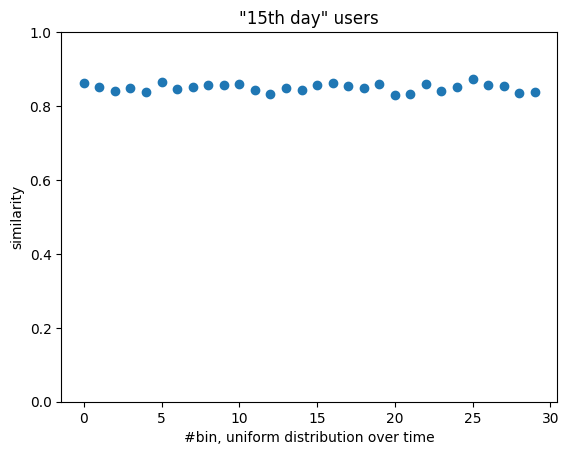

In [36]:
header = '"15th day" users'
comparison = uu_means

fig, ax = plt.subplots()
if max(comparison) > 1:
    ax.set_ylim(0,max(comparison) + 0.1)
else:
    ax.set_ylim(0,1)
if "/" in header:
    ylab = "similarity comparison"
else:
    ylab = "similarity"
ax.scatter(range(len(uu_means)), comparison)
ax.set_title(header)
ax.set_xlabel("#bin, uniform distribution over time")
ax.set_ylabel(ylab)

## 5.2 uu_means/rand_means

The 0.8-0.9 range similarity is relatively difficult to interpret. A context one can introduce is putting it in relation to random users in the dataset.

Text(0, 0.5, 'similarity comparison')

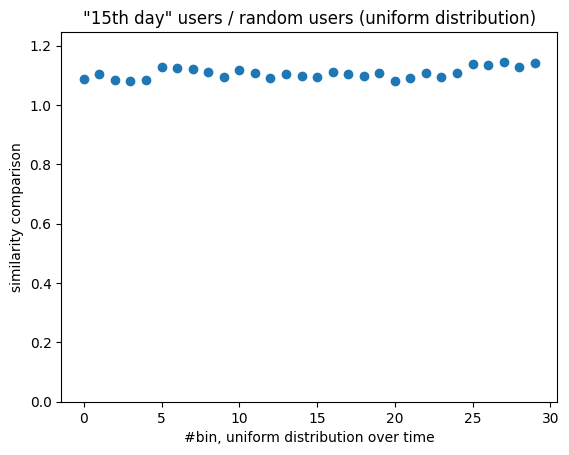

In [35]:
header = '"15th day" users / random users (uniform distribution)'
comparison = uu_means/rand_means

fig, ax = plt.subplots()
if max(comparison) > 1:
    ax.set_ylim(0,max(comparison) + 0.1)
else:
    ax.set_ylim(0,1)
if "/" in header:
    ylab = "similarity comparison"
else:
    ylab = "similarity"
ax.scatter(range(len(uu_means)), comparison)
ax.set_title(header)
ax.set_xlabel("#bin, uniform distribution over time")
ax.set_ylabel(ylab)

## 5.3 uu_means/p_means

After the presentation, I have also checked how uu_means compares to random users when more active users are favored over less active users.

What we can see is that the users that first met on the 15th day are clearly less similar in their patterns compared to relatively active users.

Text(0, 0.5, 'similarity comparison')

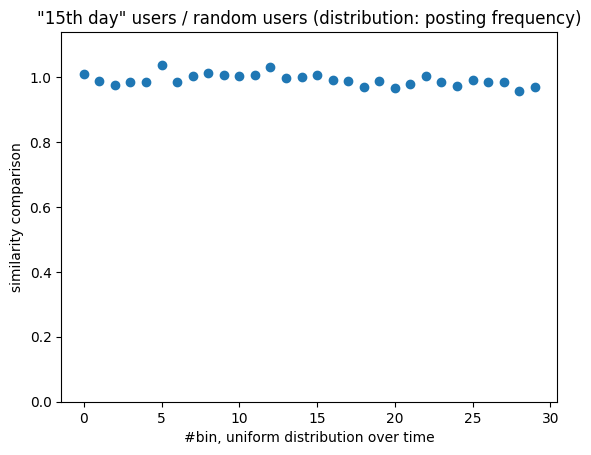

In [38]:
header = '"15th day" users / random users (distribution: posting frequency)'
comparison = uu_means/p_means

fig, ax = plt.subplots()
if max(comparison) > 1:
    ax.set_ylim(0,max(comparison) + 0.1)
else:
    ax.set_ylim(0,1)
if "/" in header:
    ylab = "similarity comparison"
else:
    ylab = "similarity"
ax.scatter(range(len(uu_means)), comparison)
ax.set_title(header)
ax.set_xlabel("#bin, uniform distribution over time")
ax.set_ylabel(ylab)

## 5.4 p_means/rand_means

Following from the findings of 5.3, it was also interesting to see by how much more active users are similar in their word choice compared to uniformly distributed random users.

Text(0, 0.5, 'similarity comparison')

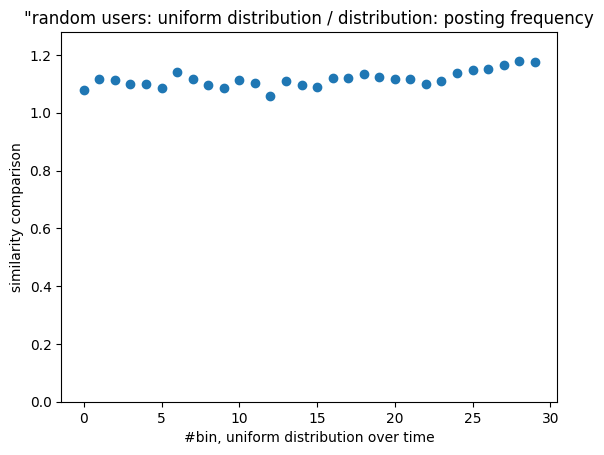

In [41]:
header = '"random users: uniform distribution / distribution: posting frequency'
comparison = p_means/rand_means

fig, ax = plt.subplots()
if max(comparison) > 1:
    ax.set_ylim(0,max(comparison) + 0.1)
else:
    ax.set_ylim(0,1)
if "/" in header:
    ylab = "similarity comparison"
else:
    ylab = "similarity"
ax.scatter(range(len(uu_means)), comparison)
ax.set_title(header)
ax.set_xlabel("#bin, uniform distribution over time")
ax.set_ylabel(ylab)

# 6. Conclusions

As was already mentioned in the presentation, there are no clear patterns when analysing the uu_similarities, especially none that we would be looking for in the long run.

W2V represents user similarities from word usage as derived by the words' contexts. It's plausible that longer lasting changes in vocabulary are connected to changes in interest or points of view. Those are expected to be longer term changes for which a window of 30 days will be insufficient.

After the presentation, as I started recreating the graphics, as I have lost my notebook with which I created the original graphs, I had experimented a bit with random users distributed according to posting frequency. One pattern that I could find while researching this is that there can be observed a faint positive trend of p_means/rand_means. This can be interpreted in the following way: People who are more frequent in posting frequency become more similar compared to random users as samples by uniform distribution.

However since this is a pattern I just discovered recently, shortly after the hand-in, I didn't go much deeper into analyzing this pattern.